<a href="https://colab.research.google.com/github/ramandrosoa/NST/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!kaggle datasets download -d ikarus777/best-artworks-of-all-time

In [2]:
#!unzip best-artworks-of-all-time.zip

In [3]:
#!kaggle datasets download -d duttadebadri/image-classification

In [4]:
#!mkdir content_image
#!unzip image-classification.zip -d content_image

In [5]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import vgg19
from keras.models import Model


## Load the content images

In [6]:
content_path = '/content/content_image/images/images'

content_dic = {'architecture' : '/architecure',
                    'art_culture' : '/art and culture',
                    'food_drink' : '/food and d rinks',
                    'travel_adventure' : '/travel and  adventure'}

content_file_list = {}
for category, folder in content_dic.items():
    full_path = os.path.join(content_path, folder.lstrip('/'))
    content_file_list [f'{category}'] = os.listdir(full_path)


## Load the style images

In [7]:
style_path = '/content/images/images'
style_folder = [f for f in os.listdir(style_path) if os.path.isdir(os.path.join(style_path,f))]
print(style_folder)

['Camille_Pissarro', 'Peter_Paul_Rubens', 'Henri_de_Toulouse-Lautrec', 'Michelangelo', 'Jan_van_Eyck', 'Titian', 'Marc_Chagall', 'Raphael', 'Salvador_Dali', 'Francisco_Goya', 'Paul_Cezanne', 'Andy_Warhol', 'Georges_Seurat', 'Rembrandt', 'Frida_Kahlo', 'Edouard_Manet', 'Mikhail_Vrubel', 'Amedeo_Modigliani', 'Hieronymus_Bosch', 'Pierre-Auguste_Renoir', 'Leonardo_da_Vinci', 'Sandro_Botticelli', 'El_Greco', 'William_Turner', 'Alfred_Sisley', 'Andrei_Rublev', 'Pablo_Picasso', 'Diego_Velazquez', 'Vincent_van_Gogh', 'Eugene_Delacroix', 'Albrecht_DuтХа├кrer', 'Rene_Magritte', 'Kazimir_Malevich', 'Pieter_Bruegel', 'Henri_Matisse', 'Paul_Gauguin', 'Edvard_Munch', 'Diego_Rivera', 'Joan_Miro', 'Paul_Klee', 'Henri_Rousseau', 'Albrecht_Du╠Иrer', 'Gustave_Courbet', 'Vasiliy_Kandinskiy', 'Piet_Mondrian', 'Caravaggio', 'Jackson_Pollock', 'Gustav_Klimt', 'Giotto_di_Bondone', 'Edgar_Degas', 'Claude_Monet']


In [8]:
style_dic = {}
for i in style_folder :
    style_dic [f'{i}'] = '/'+i

style_file_list = {}
for category, folder in style_dic.items():
    full_path = os.path.join(style_path, folder.lstrip('/'))
    style_file_list [f'{category}'] = os.listdir(full_path)

## Visualization

In [9]:
def visual (base, category, file) :

    paths = {'content' : content_path,
             'style' : style_path}
    folders = {'content' : content_dic,
               'style' : style_dic}
    files = {'content' : content_file_list,
             'style' : style_file_list}

    big_path = os.path.join(paths[base],
                           folders[base][category].lstrip('/'),
                           files[base][category][file])
    plt.figure(figsize = (30,30))
    plt.subplot(5,5,1)
    plt.title("Example of "+base, fontsize = 20)
    img = load_img(big_path)
    plt.imshow(img)

    return big_path

In [10]:
  #Get details on style images
for category in style_dic :
    print(category, len(style_file_list[category]))

Camille_Pissarro 91
Peter_Paul_Rubens 141
Henri_de_Toulouse-Lautrec 81
Michelangelo 49
Jan_van_Eyck 81
Titian 255
Marc_Chagall 239
Raphael 109
Salvador_Dali 139
Francisco_Goya 291
Paul_Cezanne 47
Andy_Warhol 181
Georges_Seurat 43
Rembrandt 262
Frida_Kahlo 120
Edouard_Manet 90
Mikhail_Vrubel 171
Amedeo_Modigliani 193
Hieronymus_Bosch 137
Pierre-Auguste_Renoir 336
Leonardo_da_Vinci 143
Sandro_Botticelli 164
El_Greco 87
William_Turner 66
Alfred_Sisley 259
Andrei_Rublev 99
Pablo_Picasso 439
Diego_Velazquez 128
Vincent_van_Gogh 877
Eugene_Delacroix 31
Albrecht_DuтХа├кrer 328
Rene_Magritte 194
Kazimir_Malevich 126
Pieter_Bruegel 134
Henri_Matisse 186
Paul_Gauguin 311
Edvard_Munch 67
Diego_Rivera 70
Joan_Miro 102
Paul_Klee 188
Henri_Rousseau 70
Albrecht_Du╠Иrer 328
Gustave_Courbet 59
Vasiliy_Kandinskiy 88
Piet_Mondrian 84
Caravaggio 55
Jackson_Pollock 24
Gustav_Klimt 117
Giotto_di_Bondone 119
Edgar_Degas 702
Claude_Monet 73


In [11]:
  #Get details on content images
for category in content_dic :
    print (category, len(content_file_list[category]))

architecture 8763
art_culture 8750
food_drink 8782
travel_adventure 8800


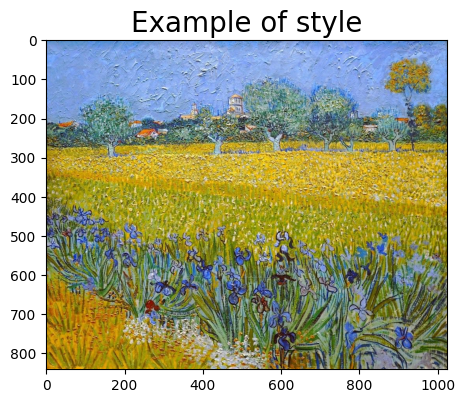

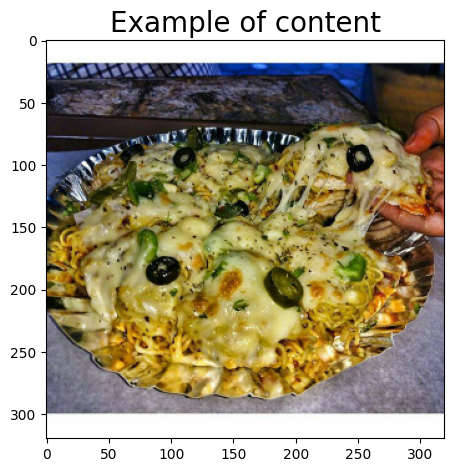

In [12]:
  #Select : content/style, category, file number
example_style = visual('style', 'Vincent_van_Gogh', 82)

example_content = visual('content','food_drink', 8099 )

## Randomly initialize the generated image

The image to be generated is based on the content image. Some updates on its pixel value will be performed until getting the appropriated generated image : a blend of the content and the style image.

First, let us reshape and normalize the selected content image.  

(1, 400, 400, 3)


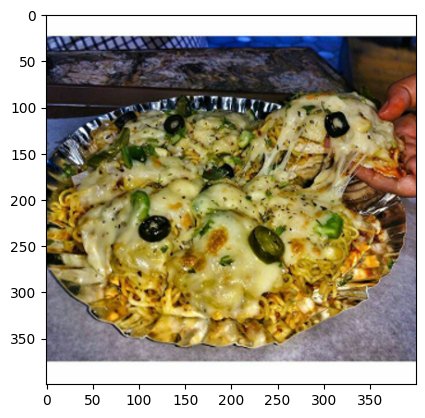

In [13]:
img_size = 400
content_image = np.array(Image.open(example_content).resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

The random initialization of the generated image can be done by adding some noises to the content image as follow :

(1, 400, 400, 3)


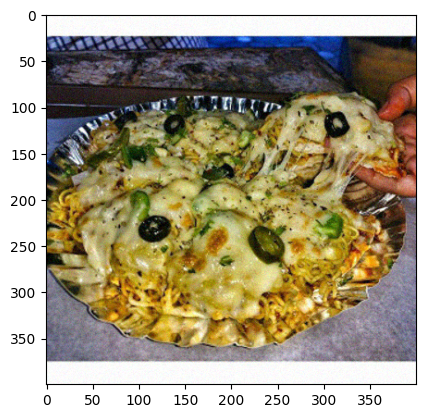

In [14]:

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.05, 0.07)

  #Add noise on the content image to get the generated image
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image,
                                   clip_value_min =0.0,
                                   clip_value_max =1)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()


Then, we reshape and normalize the selected style image.

(1, 400, 400, 3)


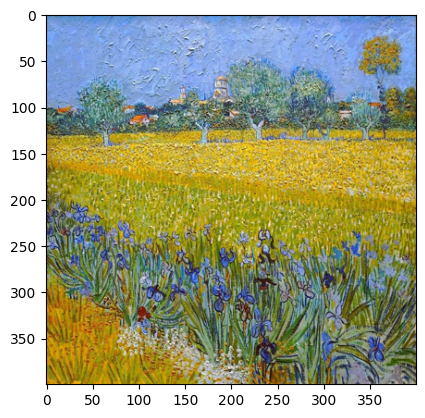

In [15]:
style_image = np.array(Image.open(example_style).resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

## Load the Pre-trained VGG19 Model

Neural Style Transfer leverages the power of pre-existing convolutional neural networks, repurposing their learned features for artistic transformation. This approach exemplifies the principle of transfer learning, where knowledge acquired by a model in one domain is adapted and applied to a different, yet related, task.

In [16]:
from keras.applications.vgg19 import VGG19
model = VGG19(include_top = False,
              input_shape = (img_size, img_size,3),
              weights ='imagenet')

In [17]:
for layer in model.layers :
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Choose the style and content layers

Each layer in the style layers will be given weights $\lambda^{[l]}$ that reflect how much each layer will contribute to the style. So the weight can be adjusted in order to control the style.

Let us give each layer equal weight, and the weights add up to 1 ($\Sigma^L_l \lambda^{[l]} = 1$).



In [18]:
STYLE_LAYERS = [('block1_conv1', 0.1),
                ('block2_conv1', 0.1),
                ('block3_conv1', 0.3),
                ('block4_conv1', 0.3),
                ('block5_conv1', 0.2)]

In [19]:
content_layers = [('block5_conv4',1)]

For the content layer, only one layer is selected and weighted to 1.

Now let us define a function which loads the pretrained model VGG19 and returns a list of the outputs for the middle layers.




In [20]:
def get_layer_outputs(model, layer_names):
    outputs = [model.get_layer(layer[0]).output
               for layer in layer_names]
    model = tf.keras.Model([model.input], outputs)
    return model

vgg_model_outputs = get_layer_outputs(model, STYLE_LAYERS+content_layers)

The outputs for the content and style layers will be saved in separate variables.

In [21]:
content_target = vgg_model_outputs(content_image) #Content encoder
style_targets = vgg_model_outputs(style_image) #Style encoder

## Compute the Cost Function J(G)

$$
J(G) = \alpha J_{content} (C,G) + β J_{style} (S,G)
$$

The cost function captures :

  - how similar the content image and the generated image are ($J_{content}(C,G)$ where C is the content and G is the generated image )
  - how similar the style image and the generated image are ($J_{style}(S,G)$ where S is the style and G is the generated image )

  


### Compute the Content Cost Function $J_{content}(C,G)$

The Content Cost Function $J_{content}(C,G)$ is given by :

$$
J_{content} (C,G) = \frac{1}{4 *n_{H}*n_{W}*n_{C}} Σ(a^{(C)} - a^{(G)})^2
$$


Let  $a^{[l](C)}$ and $a^{[l](G)}$ be the activation of the layer $l$ on the images.

$J_{content}(C,G)$ will measure the difference between the content and the generated image from this given layer.

Before computing the cost function, reshaping the activation tensors is crucial as the reshaping unrolls the spatial dimensions (height and width) into a single dimension (height*width).
This will be useful for the matrix multiplication operations used in the cost calculations.

In [22]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

      #Retrieve the dimensions from a_G
    _,n_H, n_W, n_C = a_G.get_shape().as_list()

      #Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, shape = [1,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [1,n_H*n_W,n_C])

      #Compute the cost
    J_content = (tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))))/(4*n_H*n_W*n_C)

    return J_content

 ### Compute the Style Cost Function $J_{style}(S,G)$


$$
J_{style}(S,G) = \frac{1}{4*n_C^2*(n_H*n_W)^2} \Sigma^{n_C}_{i=1}\Sigma^{n_C}_{j=1} (G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2
$$

$G^{(S)}_{(gram)i,j}$ is the Gram matrix of the style image.

$G^{(G)}_{(gram)i,j}$ is the Gram matrix of the generated image.

The Gram matrix or the "style" matrix measures the correlation of different activations across different channels.

If they are highly correlated, the activations would have some similarities such as colors, shapes or specific patterns.

The correlation between the activations represents how these different features (colors, shapes, ...) co-occur in the image. Thus, looking at the correlation enables us to capture and transfer the "style" of an image.

Let $a_{i,j,k}^{[l]}$ be the activation of layer $l$ at positions (i,j) (height and width) in channel $k$.

The Gram matrix $G_{kk'}^{[l]}$ at layer $l$ quantifies the correlation between the activations in channel $k$ and $k'$.
The correlation is calculated in each pair of numbers where $k$ and $k'$ range from 1 to $n_C^{[l]}$ (number of channels in the layer $l$).


Then, the Gram matrix in the style image is given by:  

$$
G_{kk'}^{[l](S)} = \Sigma_{i=1}^{n_H} \Sigma_{j=1}^{n_W} a_{ijk}^{[l](S)} a_{ijk'}^{[l](S)}
$$

and the Gram matrix in the generated image is :


$$
G_{kk'}^{[l](G)} = \Sigma_{i=1}^{n_H} \Sigma_{j=1}^{n_W} a_{ijk}^{[l](G)} a_{ijk'}^{[l](G)}
$$

The matrix multiplications involve a reshaping of the activation.

For the style layers, the 4D tensors (1, n_H, n_W, n_C) are reshaped into a more manageable 2D matrices (n_C, n_H * n_W).

This reshaping flattens the spatial dimensions (height and width) into a single dimension.

The Gram matrix is the computed by multiplying this reshaped matrix with its transpose, resulting in $n_C$ x $n_C$ dimensional matrix.

In [23]:
  #Define a Gram matrix function
def gram_matrix(A):
    GA = tf.linalg.matmul(A, (tf.transpose(A)))
    return GA

  #Compute the style cost for a single layer
def compute_layer_style_cost (a_S, a_G):
      #retrieve dimensions
    _,n_H, n_W, n_C = a_G.get_shape().as_list()

      #reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W)
    a_S = tf.reshape(a_S, shape=[n_H*n_W,n_C])
    a_G = tf.reshape(a_G, shape=[n_H*n_W,n_C])

      #compute the gram matrices for both images
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

      #Compute the cost
    J_style_layer = (tf.reduce_sum(tf.square(tf.subtract(GS,GG))))/(4*(n_C**2)*(n_H*n_C)**2)

    return J_style_layer


As we have already selected the style layers and weighted each of them, the style cost function is computed by the loop of the compute_layer_style_cost() function over those layers.

For each layer, we will :

  - Select the activation (the output tensor) of the current layer
  - Get the style of the style image "S" from the current layer
  - Get the style of generated image "G" from the current layer
  - Compute the style cost for the current layer
  - Add the weighted style cost to the overall style cost

Once we're done with the loop

  - Return the overall style cost

In [24]:
def compute_style_cost (style_image_output, generated_image_output, STYLE_LAYERS = STYLE_LAYERS):
    #initialize the overall style cost
  J_style = 0

    #Set a_S to be the hidden layer activation from the selected layer(STYLE_LAYERS)
    # The last element of the array contains the content layer image, which must not be used.
  a_S = style_image_output[:-1]

    #Set a_G to be the output of the chooser hidden layers
    # The last element of the list contains the content layer image, which must not be used.
  a_G = generated_image_output[:-1]
  for i , weight in zip(range(len(a_S)), STYLE_LAYERS):
      J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        #Add weight * J_style_layer of this layer to overall style cost
      J_style += weight[1]*J_style_layer

  return J_style



## Compute the Total Cost

Recall

$$
J(G) = \alpha J_{content} (C,G) + β J_{style} (S,G)
$$

In [25]:
def total_cost(J_content, J_style, alpha = 30, beta = 10):
    J = (alpha*J_content)+(beta*J_style)
    return J

## Generating the Artwork

The generated image is created by training the model.



In [26]:
  #Assign the content image to be the input of the VGG model
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
  #Set a_C to be the hidden layer activation
a_C = vgg_model_outputs(preprocessed_content) #encoding of the content image

  #Assign the input of the model to be the "style" image
preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style) #encoding of the style image

Below are the utils that display the images generated by the style transfer model.

In [27]:
def clip(image):
    return tf.clip_by_value(image, clip_value_min = 0.0,
                            clip_value_max = 1)
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor = tensor[0]
    return Image.fromarray(tensor)

## Train step

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape :
        a_G = vgg_model_outputs(generated_image) #encoding of the generated image

        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS = STYLE_LAYERS)
        J_content = compute_content_cost(a_C,a_G)
        J = total_cost(J_content, J_style, alpha = 30, beta = 10)

    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip(generated_image))

    return J

Epoch 0


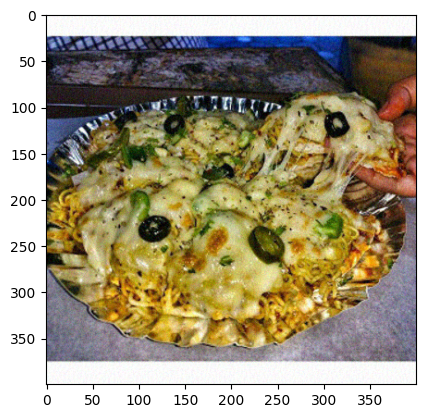

Epoch 100


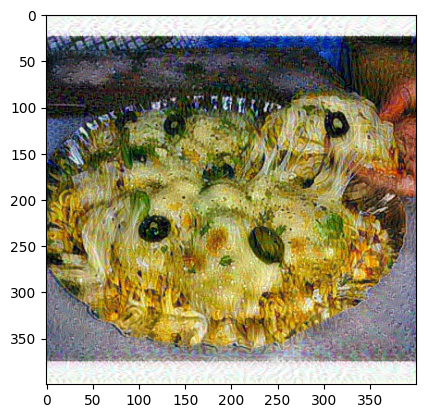

Epoch 200


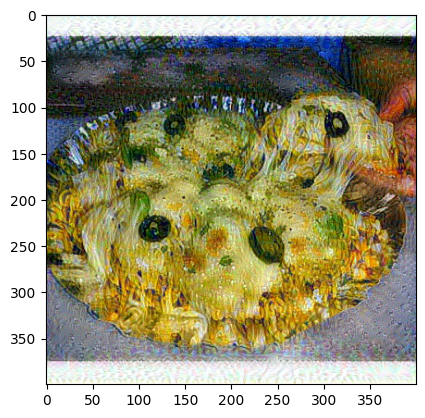

Epoch 300


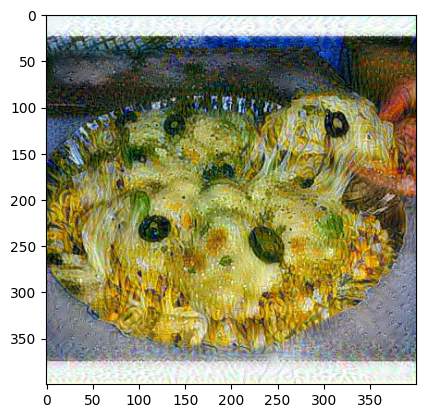

Epoch 400


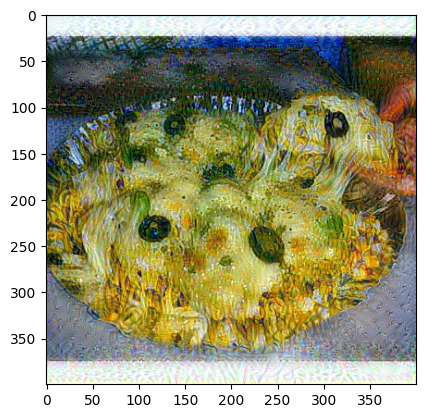

Epoch 500


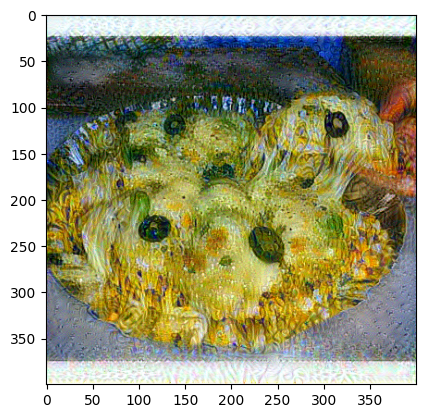

In [29]:
generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))
  #Train the model
epochs = 501
for i in range(epochs):
    train_step(generated_image)
    if i%100 == 0:
        print(f"Epoch {i}")
    if i%100 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show()

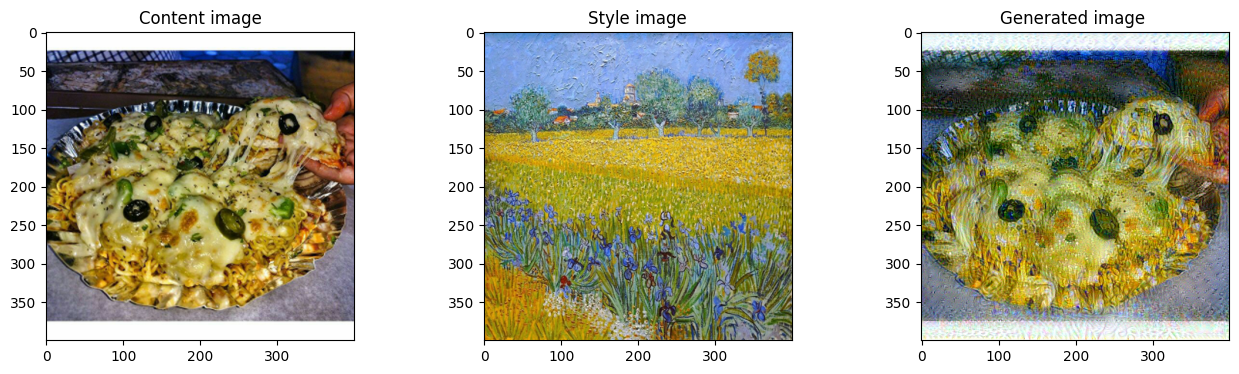

In [30]:
  #Show the 3 images in a row
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,3,1)
imshow(content_image[0])
ax.title.set_text('Content image')

ax = fig.add_subplot(1,3,2)
imshow(style_image[0])
ax.title.set_text('Style image')

ax = fig.add_subplot(1,3,3)
imshow(generated_image[0])
ax.title.set_text('Generated image ')

plt.show()

**Let us now define a new function that combines all the above code with some slight changes on the parameters. Then, we are going to use this function to generate new image from a new content and a new style**

In [103]:
def run_nst(content, style, img_size = 400,STYLE_LAYERS = STYLE_LAYERS,content_layers = content_layers,
           optimizer = optimizer , epochs = 501, alpha=20, beta=30):

        content_image = np.array(Image.open(content).resize((img_size, img_size)))
        content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
        preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
        #a_C = vgg_model_outputs(preprocessed_content) #encoding of the content image



        generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
        noise = tf.random.uniform(tf.shape(generated_image), -0.1, 0.1)
        generated_image = tf.add(generated_image, noise)
        generated_image = tf.clip_by_value(generated_image,
                                           clip_value_min =0.0,
                                           clip_value_max =1)
        generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))

        style_image = np.array(Image.open(style).resize((img_size, img_size)))
        style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
        preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
        #a_S = vgg_model_outputs(preprocessed_style) #encoding of the style image

        from keras.applications.vgg19 import VGG19
        model = VGG19(include_top = False,
                     input_shape = (img_size, img_size,3),
                     weights = 'imagenet')

        model_outputs = get_layer_outputs(model, STYLE_LAYERS+content_layers)
        a_C = model_outputs(preprocessed_content)
        a_S = model_outputs(preprocessed_style)

        @tf.function()
        def train_step(generated_image):
                with tf.GradientTape() as tape :
                        a_G = model_outputs(generated_image)
                        J_style = compute_style_cost(a_S, a_G)
                        J_content = compute_content_cost(a_C, a_G)
                        J = total_cost(J_content, J_style,
                                       alpha = alpha, beta = beta)
                grad = tape.gradient(J, generated_image)
                optimizer.apply_gradients([(grad, generated_image)])
                generated_image.assign(clip(generated_image))
                return J

        for i in range(epochs):
            total_loss = train_step(generated_image)
        final_image = tensor_to_image(generated_image)

        return final_image



In [114]:
  #make a slight change on the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

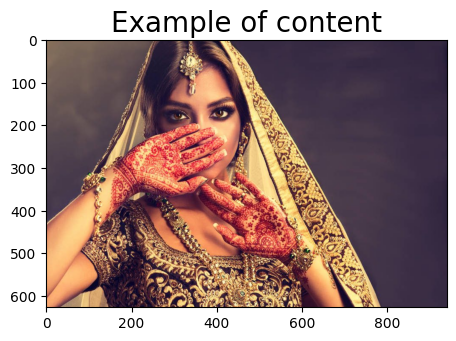

In [115]:
  #select a new content file
content = visual('content', 'art_culture', 777)


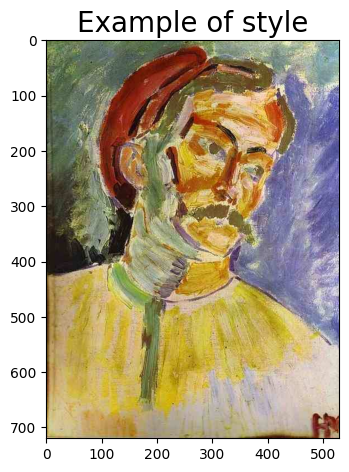

In [113]:
  #select a new style file
style = visual('style' , 'Henri_Matisse' , 48)


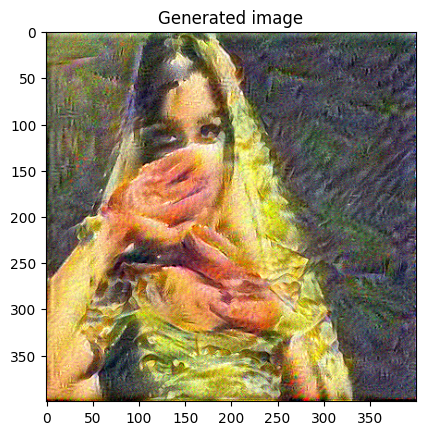

In [116]:
  #generate new image
new = run_nst(content, style, optimizer = optimizer)
plt.imshow(new)
plt.title('Generated image')
plt.show()